<a href="https://colab.research.google.com/github/dercodeKoenig/colab-KI/blob/main/relearn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir /root/.kaggle
!echo '{"username":"bpwqsdd","key":"55c6bac7a9ea2f38dd966a1d1a4e31f8"}' > /root/.kaggle/kaggle.json
!pip install numpy==1.18.5 keras-rl2 tensorflow==2.1.0 ta kaggle
!kaggle datasets download -d amin233/forex-top-currency-pairs-20002020
!unzip forex-top-currency-pairs-20002020.zip
exit()

In [58]:
import numpy as np
import gym
from gym import spaces
import tensorflow as tf

from rl.callbacks import ModelIntervalCheckpoint
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy,  BoltzmannQPolicy
from rl.memory import SequentialMemory

import time
import os
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import ta
from tqdm.notebook import tqdm
import random

seq_len = int(4*24*1)
ep_len = 1
rrw = 2


df = pd.read_csv("EURUSD-2000-2020-15m.csv")
df

,DATE_TIME,HIGH,LOW,OPEN,CLOSE
0,2000.01.03 00:00:00,1.00800,1.00730,1.00730,1.00770
1,2000.01.03 00:15:00,1.00870,1.00760,1.00780,1.00860
2,2000.01.03 00:30:00,1.00890,1.00790,1.00870,1.00790
3,2000.01.03 00:45:00,1.01320,1.00780,1.00780,1.01280
4,2000.01.03 01:00:00,1.01330,1.01200,1.01290,1.01220
...,...,...,...,...,...
500746,2020.03.19 05:00:00,1.09007,1.08790,1.08803,1.08895
500747,2020.03.19 05:15:00,1.08936,1.08807,1.08895,1.08872
500748,2020.03.19 05:30:00,1.09118,1.08853,1.08872,1.09086
500749,2020.03.19 05:45:00,1.09086,1.08946,1.09086,1.08970


In [59]:
def sample_to_x_y(sample):
        
                current_close = sample[-1].c

                prev_close = [candle.c for candle in sample]
                prev_high = [candle.h for candle in sample]
                prev_low = [candle.l for candle in sample]

                prev_sma21 = [candle.sma21 for candle in sample]
                prev_sma50 = [candle.sma50 for candle in sample]
                prev_sma200 = [candle.sma200 for candle in sample]
                
                dl = [candle.dl for candle in sample]
                dh = [candle.dh for candle in sample]

                dl_relative = [-(current_close - dl[o]) / dl[o] for o in range(seq_len)]
                dh_relative = [-(current_close - dh[o]) / dh[o] for o in range(seq_len)]
                
                prev_sma21_relative = [-(current_close - prev_sma21[o]) / prev_sma21[o] for o in range(seq_len)]
                prev_sma50_relative = [-(current_close - prev_sma50[o]) / prev_sma50[o] for o in range(seq_len)]
                prev_sma200_relative = [-(current_close - prev_sma200[o]) / prev_sma200[o] for o in range(seq_len)]

                prev_close_relative = [-(current_close - prev_close[o]) / prev_close[o] for o in range(seq_len)]
                prev_high_relative = [-(current_close - prev_high[o]) / prev_high[o] for o in range(seq_len)]
                prev_low_relative = [-(current_close - prev_low[o]) / prev_low[o] for o in range(seq_len)]

                maxval = max(prev_high_relative)
                minval = min(prev_low_relative)
                scale = 1 / (maxval - minval)

                prev_sma21_relative_scaled = [i * scale for i in prev_sma21_relative]
                prev_sma50_relative_scaled = [i * scale for i in prev_sma50_relative]
                prev_sma200_relative_scaled = [i * scale for i in prev_sma200_relative]

                prev_close_relative_scaled = [i * scale for i in prev_close_relative]
                prev_low_relative_scaled = [i * scale for i in prev_low_relative]
                prev_high_relative_scaled = [i * scale for i in prev_high_relative]

                dl_rel_scaled = [i * scale for i in dl_relative]
                dh_rel_scaled = [i * scale for i in dh_relative]
                
                prev_rsi_14 = [candle.rsi14 for candle in sample]


                x = []
                for o in range(len(prev_close)):
                    ts = []
                    ts.append(prev_close_relative_scaled[o])
                    ts.append(prev_high_relative_scaled[o])
                    ts.append(prev_low_relative_scaled[o])

                    ts.append(prev_sma21_relative_scaled[o])
                    ts.append(prev_sma50_relative_scaled[o])
                    ts.append(prev_sma200_relative_scaled[o])
                    
                    ts.append(dh_rel_scaled[o])
                    ts.append(dl_rel_scaled[o])
                    
                    ts.append(prev_rsi_14[o])

                    x.append(ts)

                x = np.array(x)
                return x
        

In [60]:
class candle_class:
    t = 0
    o = 0
    h = 0
    l = 0
    c = 0
    sma21 = 0
    sma50 = 0
    sma200 = 0
    rsi14 = 0
    atr_value = 0
    atr_fast = 0
    dh = 0
    dl = 0
    
  
class environment(gym.Env):
  candles = []
  win = 0
  current_step = 0
  startindex = 0

  def __init__(self, df):
    super(environment, self).__init__()
    # Actions of the format long, short, CLOSE.
    self.action_space = spaces.Discrete(3)
    
    
    chart = spaces.Box(low=-100, high=100, shape=(seq_len, 9), dtype=np.float32)
    self.observation_space = chart
    
    sma21_raw = list(ta.trend.SMAIndicator(df["CLOSE"], 21).sma_indicator())
    sma50_raw = list(ta.trend.SMAIndicator(df["CLOSE"], 50).sma_indicator())
    sma200_raw = list(ta.trend.SMAIndicator(df["CLOSE"], 200).sma_indicator())
    rsi_14 = [x / 50 - 1 for x in list(ta.momentum.RSIIndicator(df["CLOSE"], 14).rsi())]
    atr_value = list(ta.volatility.AverageTrueRange(df["HIGH"], df["LOW"], df["CLOSE"], 200).average_true_range())
    atr_fast = list(ta.volatility.AverageTrueRange(df["HIGH"], df["LOW"], df["CLOSE"], 9).average_true_range())
    donchi = ta.volatility.DonchianChannel(df["HIGH"], df["LOW"], df["CLOSE"], 21)
    dh = list(donchi.donchian_channel_hband())
    dl = list(donchi.donchian_channel_lband())


    for i in tqdm(range(len(df))):
      new_candle = candle_class()
      new_candle.t = i
      new_candle.o = df.iloc[i]["OPEN"]
      new_candle.h = df.iloc[i]["HIGH"]
      new_candle.l = df.iloc[i]["LOW"]
      new_candle.c = df.iloc[i]["CLOSE"]

        
      new_candle.dh = dh[i]
      new_candle.dl = dl[i]
      new_candle.sma21 = sma21_raw[i]
      new_candle.sma50 = sma50_raw[i]
      new_candle.sma200 = sma200_raw[i]
      new_candle.rsi14 = rsi_14[i]
      new_candle.atr_value = atr_value[i]
      new_candle.atr_fast = atr_fast[i]
      
      self.candles.append(new_candle)

  def _next_observation(self):
            candles = self.candles[self.current_step - seq_len + 1:self.current_step + 1]
            
            inference_data = sample_to_x_y(candles)
            return inference_data
            
  def reset(self):
    self.current_step = random.randint(200+seq_len,len(self.candles) - ep_len - 1)
    self.position = 0
    self.entry_price = 0
    self.win = 0
    self.current_win = 0
    self.startindex = self.current_step
    self.c_0 = 0
    self.c_1 = 0
    self.c_2 = 0
    self.last_reward = 0
    self.win_only = 0
    self.r_list=[]

    return self._next_observation()

  c_0 = 0
  c_1 = 0
  c_2 = 0

  last_reward = 0
  total_return = 0

  log_win_list = []
  def step(self, action):
    # Execute one time step within the environment
   
    if action == 0:
        self.c_0+=1
        self.win-=0.001
    

    atrv = self.candles[self.current_step].atr_value * 3
    close =  self.candles[self.current_step].c
    cs = 1 / atrv
    if action == 1:
      self.c_1+=1
      stop_d =  close - atrv*rrw
      stop_u =  close + atrv*1
      self.win -= 0.015 * 0.01 * cs

      ev = False
      for o in range(self.current_step+1, min(self.current_step+1 + 4*24, len(self.candles))):
        nh = self.candles[o].h
        nl = self.candles[o].l
        if stop_u < nh:
            self.win-=1
            ev = True
            break
        if stop_d > nl:
            self.win+=rrw
            ev = True
            break
      if not ev:
          self.win -= 1
        
    if action == 2:
      self.c_2+=1
      stop_d =  close - atrv*1
      stop_u =  close + atrv*rrw
      self.win -= 0.015 * 0.01 * cs
      
      ev = False
      for o in range(self.current_step+1, min(self.current_step+1 + 4*24, len(self.candles))):
        nh = self.candles[o].h
        nl = self.candles[o].l
        if stop_d > nl:
            self.win-=1
            ev = True
            break
        if stop_u < nh:
            self.win+=rrw
            ev = True
            break
      if not ev:
          self.win -= 1


    self.current_step+=1

    
    reward_raw = self.win
    reward = reward_raw - self.last_reward
    self.last_reward = reward_raw

    done = self.current_step - ep_len == self.startindex
    if done:
      self.total_return += self.win
      #print((self.c_0,self.c_1,self.c_2), round(self.win,2), round(self.total_return, 2))
      self.log_win_list.append(self.win)

      if len(self.log_win_list) > 1000:
        file2 = open("drive/MyDrive/relearn/r2_log.txt", "a")  
        for p in self.log_win_list:
          file2.write(str(p))
          file2.write("\n")
        file2.close()
        self.log_win_list = []
      
    
    obs = self._next_observation()
    return obs, reward, done, {}


env = environment(df)

  0%|          | 0/500751 [00:00<?, ?it/s]

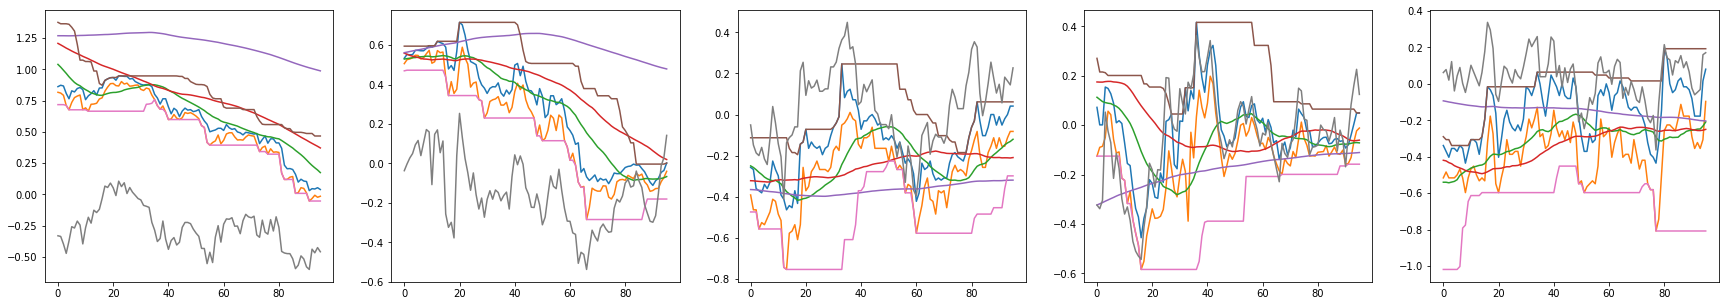

In [61]:
fig, ax = plt.subplots(1,5,figsize=(30,5))

for o in range(5):
    x = env.reset()
    x_ = np.transpose(x)
    for i in x_[1:]:
        ax[o].plot(i)


In [62]:
# Next, we build a very simple model.
inputs_1 = tf.keras.layers.Input(shape = (1, seq_len, 9))

x = tf.keras.layers.Reshape((seq_len,9))(inputs_1)

x = tf.keras.layers.Conv1D(16,2, padding="same")(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
        
x = tf.keras.layers.LSTM(16, activation = "tanh")(x)
     
x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
        
outputs = tf.keras.layers.Dense(3, activation = "linear")(x)
model = tf.keras.Model([inputs_1], outputs)
model.summary()


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1, 96, 9)]        0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 96, 9)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 96, 16)            304       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 96, 16)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 96, 16)            272       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 96, 16)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                211

In [67]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = EpsGreedyQPolicy(0.1)
#policy = BoltzmannQPolicy(0.015)
dqn = DQNAgent(model=model, nb_actions=3, memory=memory, nb_steps_warmup=10000,
               target_model_update=0.05, policy=policy, batch_size=12)

dqn.compile(tf.keras.optimizers.Adam(lr=0.0005))

In [68]:
c = ModelIntervalCheckpoint("drive/MyDrive/relearn/relearn_weights2", interval=5000, verbose=0)

In [69]:
dqn.load_weights("drive/MyDrive/relearn/relearn_weights2")

In [ ]:
dqn.fit(env, nb_steps=1000000000, visualize=False, verbose=1, callbacks=[c])

Training for 1000000000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 160s 16ms/step - reward: -0.0263
10000 episodes - episode_reward: -0.026 [-1.157, 1.982]

Interval 2 (10000 steps performed)
 4604/10000 [============>.................] - ETA: 15:54 - reward: -0.0379

In [57]:
dqn.save_weights("drive/MyDrive/relearn/relearn_weights2", overwrite=True)